In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd
import time
import matplotlib.pyplot as plt 

import os
os.chdir('../')

import data
import utils

In [3]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

In [4]:
def clean_target_predicted(target, predicted, remove_zeros = True):
    if isinstance(target, list):
        target = np.array(target)
    if isinstance(predicted, list):
        predicted = np.array(predicted)

    assert target.shape == predicted.shape, "Target and prediction don't have the same shape"
    assert isinstance(target, np.ndarray) and isinstance(predicted, np.ndarray), "Target and prediction should be numpy array"
    
    ## Removing zero observations in target data. 
    if remove_zeros:
        non_zeros = target != 0
        target = target[non_zeros]
        predicted = predicted[non_zeros]
    return target, predicted

def APE(target, predicted):
    return np.abs((target - predicted) / target)

def MAPE(target, predicted, axis = None):
    ape = APE(target, predicted)
    ape[ape == np.inf] = np.nan
    return np.nanmean(ape, axis = axis)

def MAAPE(target, predicted, axis = None):
    return np.mean(np.arctan(APE(target, predicted)), axis = axis)

def VAPE(target, predicted, axis = None):
    ape = APE(target, predicted)
    ape[ape == np.inf] = np.nan
    return np.nanvar(ape, axis = axis)

# def RMSE(target, predicted):
#     target, predicted = clean_target_predicted(target, predicted)
#     return np.sqrt(np.mean((target - predicted)**2))

In [5]:
def read_target(df, station, aggregation):
    data = df[station]

    if aggregation == 'day':
        forecast_window = 7
    elif aggregation == 'hour':
        forecast_window = 24
    elif aggregation == 'month':
        forecast_window = 12
    elif aggregation == '15mins':
        forecast_window = 8
    else:
        raise KeyError ('aggregation parameter is one of [day, hour, month, 15 mins]')

    shift_list = []
    col_list = []
    for i in range(forecast_window):
        shift_list.append(data.shift(-i))
        col_list.append('forecast_period_' + str(i + 1))
    target = pd.concat(shift_list, axis = 1)
    target.columns = col_list
    target = np.array(target.dropna())
    assert target.shape[1] == forecast_window
    target[target<10] = 0.0    ## Target less than 10 are put as zero. #Data cleaning
    return target

In [6]:
def read_prediction(model, station, aggregation):
    path = os.path.join('output', model, 'results', aggregation , station + '.json' )
    prediction = utils.read_json(path)
    prediction = np.array(prediction['prediction'])
    return prediction

In [7]:
def pre_post_split(df, date = '2020-03-15'):
    idx = dates[dates == date].index[0]
    pre = df[:idx,:]
    post = df[idx:,:]
    return pre, post

In [8]:
def analyis_process(directory, aggregation, metric):
    
    if metric == 'mape':
        func = MAPE
    elif metric == 'maape':
        func = MAAPE
    elif metric == 'vape':
        func = VAPE
    else:
        raise ValueError ("{} is not a valid metric function". format(metric))

    results = {}
    models = os.listdir(directory)

    for model in models:
        out_folder = os.path.join(directory, model, 'results', aggregation)
        
        try: 
            stations = os.listdir(out_folder)
            stations = list(set([x[:-5] for x in stations]))
            results[model] = {}
            row_list = []
            pre_post_list = []
            station_list = []
        except FileNotFoundError: 
            stations = None

        if stations is not None:

            for station in stations:
                
                target = read_target(test, station, aggregation)
                predicted = read_prediction(model, station, aggregation)[:999,:] # FIX ME 

                pre_target, post_target = pre_post_split(target)
                pre_predicted, post_predicted = pre_post_split(predicted)

                row_metric = func(target, predicted, axis = 1)
                pre_metric = func(pre_target, pre_predicted)
                post_metric = func(post_target, post_predicted)
                row_list.append(row_metric)
                pre_post_list.append([pre_metric, post_metric])
                station_list.append(station)
                
            #Store results
            results[model]['trend'] = row_list
            results[model]['pre_post'] = pre_post_list
            results[model]['stations'] = station_list

    sys_evolution_df = {}
    pre_post_df = {}

    for model in results.keys():
        value = np.vstack(results[model]['trend']).T
        value = pd.DataFrame(value, columns = results[model]['stations'], index = dates[:999]) #FIX ME
        value['mean_metric'] = value.mean(axis = 1)
        sys_evolution_df[model] = value

        df = pd.DataFrame(data = results[model]['pre_post'], 
                        index = results[model]['stations'], columns = ['pre', 'post'])
        pre_post_df[model] = df

    return sys_evolution_df, pre_post_df

In [9]:
def plot_model_results(sys_evolution, pre_post):
    rows = 2 
    cols = len(sys_evolution)
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize = (12,8))

    counter = 0
    for model in sys_evolution.keys():
        sys_evolution[model]['mean_metric'].plot(ax = axs[0][counter])
        pre_post[model].plot.scatter(x = 'pre', y = 'post', ax = axs[1][counter])
        axs[1][counter].plot([0, 4], [0, 4], linewidth=2)
        axs[0][counter].set_title(model)
        counter +=1

In [10]:
def linear_regression(results):

    models_list = []
    models = list(results.keys())

    for model in models:
        # pre_name = 'pre_' + model
        # post_name = 'post_' + model
        # to_drop = ['(14004) museo del oro', '(10006) san victorino']
        xy = results[model]#.drop(index = to_drop)
        x = sm.add_constant(xy['pre'].rename('pre COVID-19'), prepend=False)
        y = xy['post']
        model = sm.OLS(y, x).fit()
        models_list.append(model)

    ols_results = summary_col(models_list,stars=True, info_dict = {"N":lambda x:(x.nobs)},
                              model_names = models, float_format='%.3f')

    return ols_results

In [11]:
directory = 'output'
data_directory = 'data'
aggregation = 'day'

train, test = data.split_data(data_directory, aggregation = aggregation)
dates = pd.to_datetime(test[['year', 'month', 'day']])
dates = dates.reset_index(drop = True)

In [12]:
trend, pre_post = analyis_process(directory, aggregation, metric = 'mape')

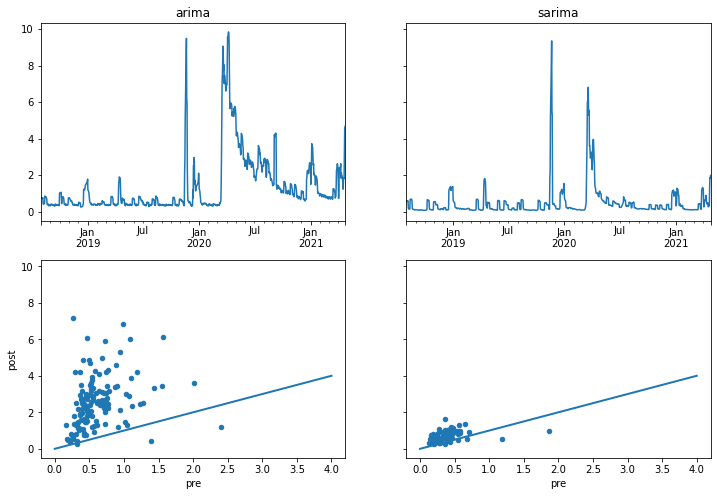

In [13]:
plot_model_results(trend, pre_post)

In [14]:
linear_regression(pre_post)

,arima,sarima
pre COVID-19,1.195***,0.536***
,(0.320),(0.113)
const,1.795***,0.463***
,(0.220),(0.046)
R-squared,0.088,0.192
R-squared Adj.,0.082,0.184
N,147.0000,97.0000


There are some stations that have very little number of observations. For those stations, I should filter if there are less than 10 transactions per day. 

Also, in read_target, it seems that I drop np.nan. This shoul not happen. Check. 